# Qualitative analysis
by: Kaike Wesley Reis

## Modules

In [7]:
# General
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import joblib
from sklearn.ensemble import RandomForestClassifier

# Qualitative analysis
import shap

In [19]:
# Set plot parameters
import matplotlib as mpl
FONTSIZE = 18

mpl.rcParams['font.family'] = 'Arial'
plt.rc('font',family='Arial', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE + 7, labelsize=FONTSIZE)
plt.rc('xtick', labelsize=FONTSIZE)
plt.rc('ytick', labelsize=FONTSIZE)
plt.rc('legend', fontsize=FONTSIZE)

# For ipynb
%matplotlib inline

In [9]:
# SHAP version to avoid  bugs
shap.__version__

'0.38.1'

# Imports

In [10]:
# Model
model_ml = joblib.load('results_modelsDevelopment/model_rfc_oversampled.sav')

In [11]:
# Trainset (SMOTE)
x_train = pd.read_csv('results_modelsDevelopment/x_train_SMOTE.csv')
y_train = pd.read_csv('results_modelsDevelopment/y_train_SMOTE.csv')

In [12]:
# Testset
x_test = pd.read_csv('results_modelsDevelopment/x_test.csv')
y_test = pd.read_csv('results_modelsDevelopment/y_test.csv')

In [13]:
# Backtest
x_resp = pd.read_csv('results_modelsDevelopment/x_resp.csv')
y_resp = np.zeros((len(x_resp),))

# Useful infos

In [17]:
# Best model parameters
model_ml.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1206,
 'verbose': 0,
 'warm_start': True}

In [18]:
# How many samples in backtest was predicted correct for the best model
y_pred_resp = model_ml.predict(x_resp)

# Show result
print('From',len(y_resp),'samples,',sum(y_pred_resp == y_resp),'was correct.')

From 26 samples, 24 was correct.


# Qualitative 1 - Feature Importance (only Ensemble/LR models)

In [20]:
df_featImp = pd.DataFrame(columns=['Feature', 'Importance'])
df_featImp['Feature'] = x_train.columns
df_featImp['Importance'] = model_ml.feature_importances_
df_featImp.sort_values('Importance', ascending=False, inplace=True)

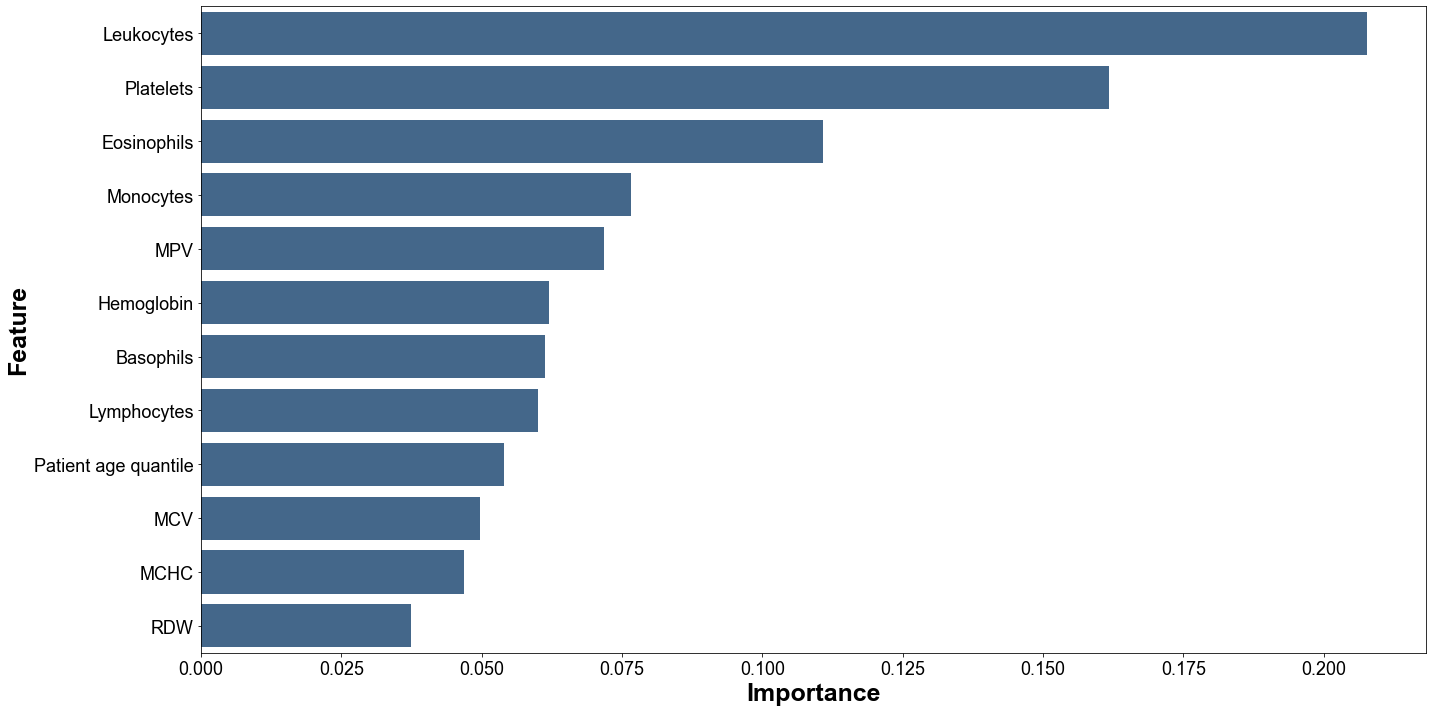

In [21]:
# Plot
fig = plt.figure(figsize=(20,10))
sns.barplot(x="Importance",y='Feature', data=df_featImp, color='#386796')
plt.xlabel('Importance',fontsize=25,fontweight='bold')
plt.ylabel('Feature',fontsize=25,fontweight='bold')
plt.tight_layout()
plt.show()
fig.savefig('results_paperPlots/feature_importance.png', bbox_inches='tight')
plt.close();

# Qualitative 2 - Scatter Plots for relevant features

## Plots - Feature VS COVID-19 Presence

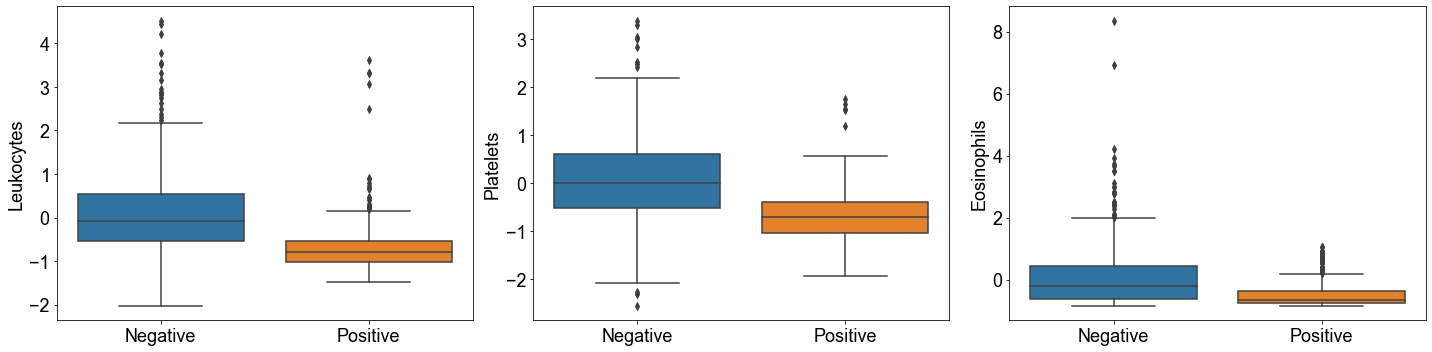

In [22]:
#mpl.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.boxplot(x=y_train['COVID-19 Exam result'], y=x_train['Leukocytes'], ax=ax[0])
sns.boxplot(x=y_train['COVID-19 Exam result'], y=x_train['Platelets'], ax=ax[1])
sns.boxplot(x=y_train['COVID-19 Exam result'], y=x_train['Eosinophils'], ax=ax[2])
ax[0].set_xlabel('');
ax[1].set_xlabel('');
ax[2].set_xlabel('');
ax[0].set_xticklabels(['Negative','Positive']);
ax[1].set_xticklabels(['Negative','Positive']);
ax[2].set_xticklabels(['Negative','Positive']);
plt.tight_layout()
plt.show()
fig.savefig('results_paperPlots/boxplot_imp_features.png', bbox_inches='tight')
plt.close();

# Qualitative analysis 3 - SHAP

## Prepare SHAP

In [24]:
# Original (margin) result explainer
explainer = shap.TreeExplainer(model=model_ml)

In [25]:
# Get SHAP values for trainset
shap_values_train = explainer.shap_values(x_train,y_train)

## Plot 3.1 - Trainset Overall contributions

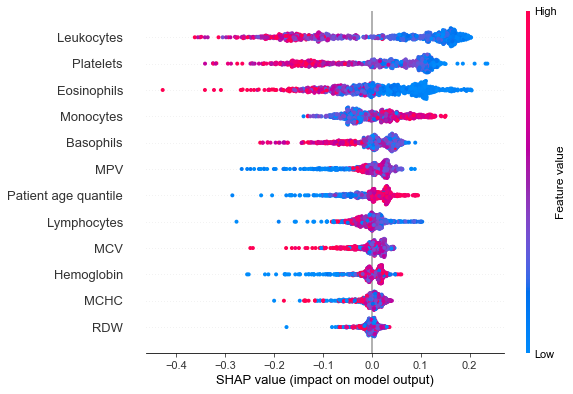

<Figure size 432x288 with 0 Axes>

In [27]:
# summarize the effects of all the features - Class 1
fig = plt.figure(figsize=(20,20))
shap.summary_plot(shap_values_train[1], x_train, plot_type="dot")
plt.tight_layout()
plt.show()
fig.savefig('results_paperPlots/shap_summary.png', bbox_inches='tight');
plt.close();

## Plot 3.2 - Backtest Wrong results with SHAP Analysis

### Get wrong samples by chosen model

In [28]:
# Predict
y_pred_resp = model_ml.predict(x_resp)

In [29]:
# Get indexes where the model got a wrong predict, i.e. said that the pacient got COVID-19
idx_resp = np.where(y_resp != y_pred_resp)[0]

In [30]:
# Samples size
print('From',len(x_resp),'samples',len(idx_resp),'was predicted as False Positive')

From 26 samples 2 was predicted as False Positive


In [31]:
# Get samples
sample_resp = x_resp.loc[idx_resp,:]

In [33]:
# Get baseline value (threshold selection)
expected_value = explainer.expected_value
expected_value

array([0.5, 0.5])

### SHAP plot - Eval an wrong sample of Any Respiratory Disease

In [51]:
# Calculate SHAP for that first wrong sample
shap_values_backtest = explainer.shap_values(sample_resp.loc[idx_resp[0],:])

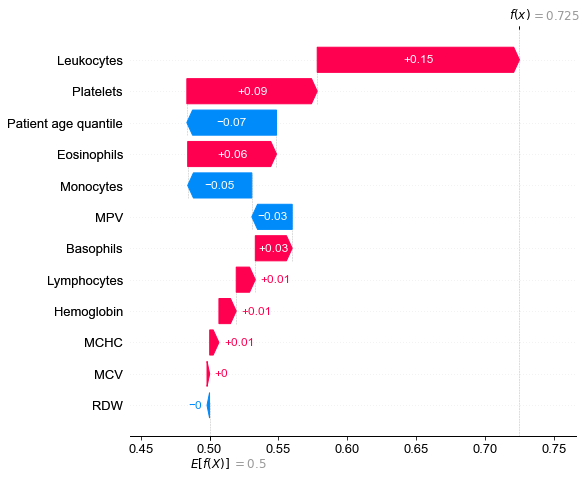

<Figure size 432x288 with 0 Axes>

In [58]:
# Plot SHAP
fig = plt.figure(figsize=(20,10))
shap.plots._waterfall.waterfall_legacy(expected_value[1], shap_values_backtest[1].reshape(-1), None,
                                       feature_names=x_train.columns, max_display=15);
plt.tight_layout();
plt.show();
fig.savefig('results_paperPlots/shap_backtest1.png', bbox_inches='tight');
plt.close();

In [59]:
# Calculate SHAP for that first wrong sample
shap_values_backtest = explainer.shap_values(sample_resp.loc[idx_resp[1],:])

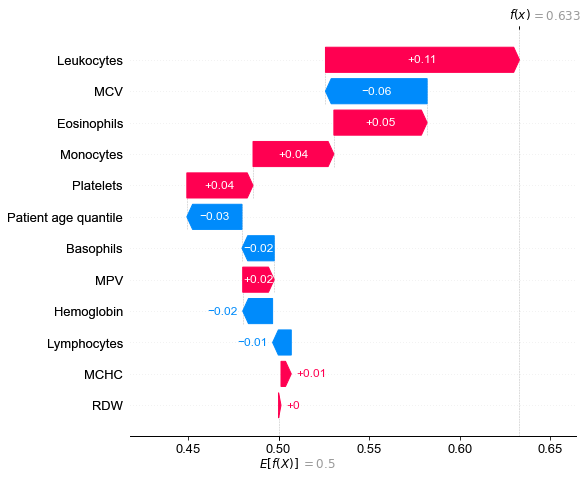

<Figure size 432x288 with 0 Axes>

In [60]:
# Plot SHAP
fig = plt.figure(figsize=(20,10))
shap.plots._waterfall.waterfall_legacy(expected_value[1], shap_values_backtest[1].reshape(-1), None,
                                       feature_names=x_train.columns, max_display=15);
plt.tight_layout();
plt.show();
fig.savefig('results_paperPlots/shap_backtest2.png', bbox_inches='tight');
plt.close();

## Plot 3.3 - PDP plot

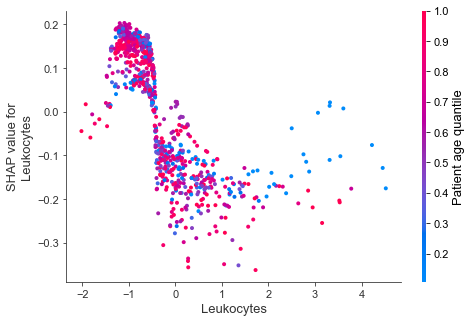

In [64]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Leukocytes", shap_values_train[1], x_train, interaction_index='Patient age quantile')